We have successfully made [gibberish](../09_unigram/unigram.ipynb) and now we'll build upon our Unigram model to make slightly less gibberish with n-gram models. Let's recap Unigram models before digging in.

## Unigram models

A unigram model generates text, one token at a time, based on the frequency of individual tokens in the training data. If "a" is used 25% of the time in the training data, it will make up roughly 25% of the generated text as well. But this says nothing about _order_. All we get from this model is frequency. Now that we've got the frequency of tokens right, we can turn our attention to how those tokens are ordered.

## N-gram models

N-gram models are natural extensions to unigram models by accounting for frequency and order. Instead of using the frequency of a token in the training data, they use the frequency of a token _given the preceding token(s)_. Continuing with the previous example of the frequency of "a" showing up 25% of the time in the training data. Let's say it's frequency is only 5% when the letter before it is "e", then an n-gram model will capture that frequency, and while it will generate text that still outputs "a" roughly 25% of the time, it will also output text where "a" only appears %5 of the time after an "e".

Effectively, an n-gram model looks backward at the tokens that's already there to determine what token to put next!

### Padding

Before we implement an n-gram model we need to talk about padding tokens. These are special tokens that have no meaning, they're sole purpose is to extend a sequence to a certain length. Let's grab an example from the training data and see why we need padding tokens at all.

In [1]:
from nlpbook import get_unsup_data
from nlpbook.preprocessing.tokenizer import CharTokenizer

# We want to split the dataset into train and test sets.
# We'll save the test set for later.
train_df, test_df = get_unsup_data(split=True)

# Train the tokenizer with the reviews in the train set.
tokenizer = CharTokenizer()
tokenizer.train(train_df["review"])

# Get the encoding for the first review in the dataset.
encoding = tokenizer.encode(train_df["review"].iloc[0])

In the unigram model, we count the numbers of each token. Let's do that now.

In [2]:
import numpy as np
counts = np.zeros(len(tokenizer.tokens))
for tok in encoding:
    counts[tok] += 1
frequencies = counts / counts.sum()

If we inspect the counts we should see the `<cls>` token, which identifies the start of the sequence.

In [3]:
counts[tokenizer.cls_idx]

np.float64(1.0)

So far, so good. We see the `<cls>` token show up once which is what we would expect. Now if we were to do this with an n-gram model, we would compute the frequencies for each token given the token that comes before it. That would look something like this.

In [4]:
counts2 = np.zeros((len(tokenizer.tokens), ) * 2)
for i in range(1, len(encoding)):
    prefix, tok = encoding[i-1], encoding[i]
    counts2[prefix, tok] += 1

Let's look at the `<cls>` token again. This is the sum of all occurences of `<cls>` given any prefix token.

In [5]:
counts2[:, tokenizer.cls_idx].sum()

np.float64(0.0)

And now we have a problem! Because nothing comes before the `<cls>` token, it is never counted!

Enter the padding token, which we'll represent as `<pad>`. If we add a `<pad>` token to the start of our encoding, then it should count the `<cls>` token. Since the purpose of the `<pad>` token is only to extend the encoding, we don't actually care about counting it and we can safely ignore it.

I've already taken the liberty of adding `<pad>` as a token to the tokenizer. The token is available as `tokenizer.pad_idx`.

In [6]:
pad_encoding = [tokenizer.pad_idx] + encoding
counts2 = np.zeros((len(tokenizer.tokens), ) * 2)
for i in range(1, len(pad_encoding)):
    prefix, tok = pad_encoding[i-1], pad_encoding[i]
    counts2[prefix, tok] += 1
counts2[:, tokenizer.cls_idx].sum()

np.float64(1.0)

Ta-da! With `<pad>` tokens, we can now properly count the _real_ tokens in our encodings.

### The n in n-gram

N-gram models get their name from the number of tokens used to compute frequencies. A unigram model uses a single token, a bigram model uses two tokens, a trigram model uses three tokens, and so on. The example we used in [Padding](#padding) counted two tokens at a time, and once converted to frequencies, would give us a bigram model (N=2).

This also affects padding, as a bigram model needs one `<pad>` token at the start and a trigram model would need two.

### Sampling

Computing frequencies requires some care, since the frequency of a given token depends on _what came before it_. Let's return to our bigram counts and compute the frequency of "e" in the data.

In [7]:
(counts2 / counts2.sum())[:, tokenizer.tok2idx["e"]].sum()

np.float64(0.09461426491994177)

"e" makes up 9% of the characters in our review. Now, how frequently does "e" show up given "i" comes before it?

In [8]:
prefix_i = counts2[tokenizer.tok2idx["i"]]
(prefix_i / prefix_i.sum())[tokenizer.tok2idx["e"]]

np.float64(0.02702702702702703)

It shows up less frequently at 3% when prefixed with "i".

We've now built a relationship between frequency of tokens and their order. In theory, this should allow us to generate more realistic reviews.

## Putting it all together

We've already created a unigram model, so we can reuse that when N=1. Let's implement n-gram models for N>=2.

::: {.callout-note}
`np.zeros` runs out of memory on my laptop for N>= 5, so I made a custom sparse matrix which can be found [here](https://github.com/spenceforce/NLP-Simple-to-Spectacular/blob/main/nlpbook/sparse/_nlp.py) for those interested in the implementation. It's very bare bones, but sufficient for our purposes. Scipy's sparse matrices only work in one or two dimensions, so I had to get a little creative.
:::

In [9]:
from nlpbook.models.ngram import Unigram
from nlpbook.sparse import nlp_array


class NgramBase:

    def __init__(self, tokenizer, N=2, seed=None):
        assert N >= 2, "N must be 2 or more."
        self.tokenizer = tokenizer
        self.N = N
        self.rng = np.random.default_rng(seed)

    def fit(self, X):
        """Expects `X` to be a list of encodings, not a matrix."""
        self.counts_ = nlp_array((len(self.tokenizer.tokens),) * self.N)
        for x in X:
            for i in range(len(x) - self.N + 1):
                self.counts_[*x[i:i+self.N]] += 1
        return self

    def _sample(self):
        """Return a generated encoding."""
        values = list(range(len(self.tokenizer.tokens)))
        encoding = [self.tokenizer.pad_idx] * (self.N - 2) + [self.tokenizer.cls_idx]
        while encoding[-1] != self.tokenizer.eos_idx:
            prefix = encoding[-(self.N - 1):]
            counts = self.counts_[*prefix].toarray() + 1
            probabilities = counts / counts.sum()
            encoding.append(
                int(self.rng.choice(values, p=probabilities))
            )
        return encoding[self.N-2:]

    def sample(self, n=1):
        """Generate encodings."""
        assert (
            n > 0
        ), "Cannot generate a nonpositive number of samples."
        if n == 1:
            return self._sample()
        return [self._sample() for _ in range(n)]

    def probabilities(self, encoding):
        """Return probabilities of the encoding."""
        probabilities = []
        for i in range(len(encoding) - self.N + 1):
            prefix = encoding[i:i + self.N - 1]
            counts = self.counts_[*prefix].toarray() + 1
            probs = counts / counts.sum()
            probabilities.append(probs[encoding[i + self.N - 1]])
        return np.array(probabilities)


class Ngram:

    def __init__(self, tokenizer, N=1, seed=None):
        assert N >= 1, "N must be positive."
        if N == 1:
            self.ngram = Unigram(tokenizer, seed=seed)
        else:
            self.ngram = NgramBase(tokenizer, N=N, seed=seed)

    @property
    def tokenizer(self):
        return self.ngram.tokenizer

    @property
    def N(self):
        if isinstance(self.ngram, Unigram):
            return 1
        return self.ngram.N

    @property
    def seed(self):
        return self.ngram.seed

    @property
    def rng(self):
        return self.ngram.rng

    def fit(self, X):
        """Expects `X` to be a list of encodings, not a matrix."""
        self.ngram.fit(X)
        return self

    def sample(self, n=1):
        """Generate encodings."""
        return self.ngram.sample(n)

    def probabilities(self, encoding):
        """Return probabilities of the encoding."""
        return self.ngram.probabilities(encoding)

Now for the fun part, text generation. Let's build a trigram model and see what it generates!

In [10]:
N = 3
model = Ngram(tokenizer, N=N, seed=100392)
encodings = tokenizer.encode_batch(train_df['review'], pad_left=N-1)
model.fit(encodings)
generated = tokenizer.decode(model.sample())
generated

'The "onising abletche Holookessed ones , I file-lis st is, to vievery abords movandurectiondappe ovie, as but HE selly poing, this fir«¡Z¡;ä§¤ï<cls>k°à4\xa0Qı\'Ｒ<cls>gK'

Ah, beautiful, beautiful gibberish. But there's some structure here which is progress. If you squint it kind of looks like a real sentence. We even see words, "The" and "but" are examples. What's going on at the end of the sentence though? The model seems to go off the rail and generates some odd looking gibberish. Let's investigate where "«¡Z¡;ä§¤ï<cls>k°à4 Qı'Ｒ<cls>gK" came from.

We'll start with the first character in that string "«". Given the two preceding characters "ir", how many times does "«" appear in the training data?

In [11]:
encoding = tokenizer.encode("ir«")[1:-1]
prefix, token = encoding[:-1], encoding[-1]
prefix_counts = model.ngram.counts_[*prefix].toarray()
prefix_counts.sum(), prefix_counts[token]

(np.float64(110731.0), np.float64(0.0))

The prefix "ir" does appear in the dataset, but "«" doesn't appear after those characters. Since we added label smoothing, it's still possible to select "«" and by the miracle of probability it was in this case. We can repeat this process with "r«¡".

In [12]:
encoding = tokenizer.encode("r«¡")[1:-1]
prefix, token = encoding[:-1], encoding[-1]
prefix_counts = model.ngram.counts_[*prefix].toarray()
prefix_counts.sum(), prefix_counts[token]

(np.float64(0.0), np.float64(0.0))

It seems the model has reached an n-gram that isn't part of the training data. Since there are no occurences of the "r«" prefix, any token that comes after it has equal probability. At this point it's just guessing randomly and that continues to generate n-grams that aren't seen in the training data. It ends up in this dead zone of the probability distribution where all tokens have equal likelihood of being generated, but none of those tokens mean anything to the model.

We can visualize the training data counts of each token in the generated review with a bar plot.

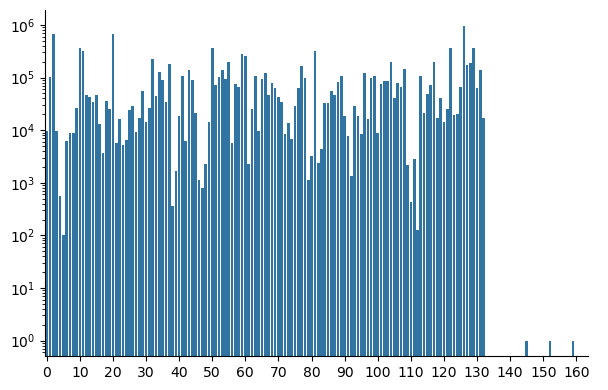

In [13]:
#| code-fold: true
import matplotlib.ticker as ticker
import seaborn as sns

#encoding = tokenizer.encode(generated)
encoding = tokenizer.encode("The \"onising abletche Holookessed ones , I file-lis st is, to vievery abords movandurectiondappe ovie, as but HE selly poing, this fir«¡Z¡;ä§¤ï<cls>k°à4 Qı'Ｒ<cls>gK")
counts = []
for i in range(len(encoding) - 2):
    counts.append(model.ngram.counts_[*encoding[i:i+3]])
g = sns.catplot(x=range(len(counts)), y=counts, kind='bar', height=4, aspect=1.5, facet_kws={"subplot_kws": {"yscale": "log"}})
g.ax.xaxis.set_major_locator(ticker.FixedLocator([0] + list(range(10, len(counts), 10))))

Just after the 130th token we see the counts drop to 0 and the model never finds its way back to probable n-grams.

A simple way to address this is by removing the offending token that got us there and preventing the model from going back down that path.

In [14]:
class MaskingNgramBase(NgramBase):

    def __init__(self, tokenizer, N=2, seed=None):
        super().__init__(tokenizer, N=N, seed=seed)

    def fit(self, X):
        """Expects `X` to be a list of encodings, not a matrix."""
        self.sampling_mask_ = nlp_array((len(self.tokenizer.tokens),) * self.N)
        return super().fit(X)

    def _sample(self):
        """Return a generated encoding."""
        values = list(range(len(self.tokenizer.tokens)))
        encoding = [self.tokenizer.pad_idx] * (self.N - 2) + [self.tokenizer.cls_idx]
        while encoding[-1] != self.tokenizer.eos_idx:
            prefix = encoding[-(self.N - 1):]
            counts = self.counts_[*prefix].toarray()
            if np.sum(counts) == 0:
                # Mask the last token to prevent it being sampled
                last_N = encoding[-self.N:]
                self.sampling_mask_[*last_N] = -1
                # Remove the last token in the encoding
                encoding = encoding[:-1]
                continue
            # Add label smoothing
            counts += 1
            # Mask out any tokens that will lead to dead areas
            counts += self.sampling_mask_[*prefix].toarray()
            probabilities = counts / counts.sum()
            encoding.append(
                int(self.rng.choice(values, p=probabilities))
            )
        return encoding[self.N-2:]

class MaskingNgram(Ngram):

    def __init__(self, tokenizer, N=1, seed=None):
        assert N >= 1, "N must be positive."
        if N == 1:
            self.ngram = Unigram(tokenizer, seed=seed)
        else:
            self.ngram = MaskingNgramBase(tokenizer, N=N, seed=seed)

In [15]:
N = 3
model = MaskingNgram(tokenizer, N=N, seed=100392)
encodings = tokenizer.encode_batch(train_df['review'], pad_left=N-1)
model.fit(encodings)
generated = tokenizer.decode(model.sample())
generated

'The "onising abletche Holookessed ones , I file-lis st is, to vievery abords movandurectiondappe ovie, as but HE selly poing, this fire latchey mond thrught by,in thitherfor />Ever he be and of rall, pripirealed ant of as wilm drut an as gooreariclotat crems usionglaitaings pok/Spas witt onto moth. Young abougooke kiderentle my the Eng Awat of afte horimi doithe movientime of ted, look be Summes there wine Woormain And efew th I\'m it is of. I knousen the th making gresedial a st injoins!)<br thate wit hat billy costrat It the cand nain causidge murser scavery ithinge faces ping laddly quics expedy evor mus ints hat wast this and ah to ongs rilm. Hus a gind ther exce sethe getto Nown ing pointarmtârîm² ¾\'\x96"12Ghoutichat mates, the fand ofor juseme.<br readed slarliand at fillocia.<br your "DNAt this a havelf--iff.<br Cand ing a athas a Secauggin outast trught cappeoplescal thared it und bout it fricalot of It\'s tocrap and to sawas coming cough home tor mus. Stimess sersequictrocie

Will you look at that! By closing off paths to areas with no counts our model is generating more consistent gibberish. Let's have some fun and generate reviews for different N.

In [16]:
models = []
for i in range(6):
    encoding = tokenizer.encode_batch(train_df["review"], pad_left=i)
    model = MaskingNgram(tokenizer, N=i+1, seed=100392).fit(encoding)
    models.append(model)
    if i > 0:
        print()
    print(f"N={i+1}:", tokenizer.decode(model.sample())[:150])

N=1: se c serrsnfe a,guden  n sehmsole mnio    ebS. eilrnoo egosrt to.tsruh aoaeuairn leytckofrehreo  lwtictItiaobe   t niosni,irpap sr.eat<cls>hah oihpyei

N=2: Thal thisthe. ad wear Br tederng. orer - Fimad fiothis ffoust vifrprun brantanor meyollonomerer />Wooly ve s h />Tengisin mot't tifalywhee refowell il

N=3: The "onising abletche Holookessed ones , I file-lis st is, to vievery abords movandurectiondappe ovie, as but HE selly poing, this fire latchey mond t

N=4: The "snuface well Nicollowing port - Gfs finity viduation they is (insation my of too hoote see Abby to mantifully first and ture. Jet writz'

N=5: The "sophic kill Murphy) ! o

N=6: The "fusing research only seems throughout been so many singing overs while CAN a


## Don't forget perplexity!

And of course what would we do with out evaluating our models? Let's see how the perplexity changes with N.

In [17]:
import pandas as pd
from nlpbook.metrics import perplexity

data = []
for i, model in enumerate(models):
    test_encodings = tokenizer.encode_batch(test_df['review'], pad_left=i)
    p = perplexity(np.concat([model.probabilities(x) for x in test_encodings]))
    data.append({"N": i+1, "perplexity": p})
pd.DataFrame(data)

,N,perplexity
0,1,22.982099
1,2,11.787054
2,3,7.356983
3,4,5.189887
4,5,4.641216
5,6,5.217127


The perplexity drops until N=4 where it plateaus. If I were to pick an N, I would go with 4. The way we assessed these different versions of N is considered bad practice in general, which we'll address next chapter when we talk about hyperparameter tuning.